# SisFall

In [1]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import CuDNNLSTM, CuDNNGRU, Dropout
from keras.optimizers import Adam, SGD
import math
import random
import numpy as np
import os

import itertools

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from keras.models import load_model
from keras.utils import to_categorical

# Import own methods

import data_generator as dg
import ml_utils as mlu


Using TensorFlow backend.


Checking if GPU are avaliable

In [2]:
from tensorflow.python.client import device_lib
from keras import backend as K

print("Process Units detected by tensorflow: ")
print(device_lib.list_local_devices())


print("GPUs used by keras:")
K.tensorflow_backend._get_available_gpus()

Process Units detected by tensorflow: 
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5101305683606184676
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2768344886711097236
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6815503238966718499
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10592655770
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9017254389616330500
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
GPUs used by keras:


['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
dataTrWinValues, dataTrWinLabel, dataTestWinValues, dataTestWinLabel, dataWinOrganization = \
dg.loadDataSetInBlocks('../', nTestUsers=8, windowSize=256, stride=128)

Loading data...

Divided (train - test) found. Loading...

Data loaded correctly

Estructuring data in blocks...

Data generated correctly


In [4]:
unique, counts = np.unique(dataTrWinLabel, return_counts=True)

dict_counts = dict(zip(unique,counts))
print(dict_counts)

N_bkg = dict_counts[0]
N_alert = dict_counts[1]
N_fall = dict_counts[2]

print(N_bkg, N_alert, N_fall)

w_bkg = 1
w_alert = N_bkg / N_alert 
w_fall = N_bkg / N_fall

target_weights = [w_bkg,w_alert,w_fall]
print(target_weights)


{0: 89631, 1: 1031, 2: 3380}
89631 1031 3380
[1, 86.93598448108632, 26.518047337278105]


In [5]:
###############################################################
#
# The loss function implemented doesn't work with int targets
from keras.utils import to_categorical

dataTrWinLabelOneHot = to_categorical(dataTrWinLabel)
dataTestWinLabelOneHot = to_categorical(dataTestWinLabel)

###############################################################

## Paper model

In [9]:
model_paper_model_100ep = Sequential()

model_paper_model_100ep.add(Dense(32, batch_input_shape = (None, 256, 3)))

model_paper_model_100ep.add(BatchNormalization())

model_paper_model_100ep.add(Dropout(0.5))

model_paper_model_100ep.add(CuDNNLSTM((32), return_sequences=True))

model_paper_model_100ep.add(Dropout(0.5))

model_paper_model_100ep.add(CuDNNLSTM((32)))

model_paper_model_100ep.add(Dropout(0.5))

model_paper_model_100ep.add(Dense(3,activation='softmax'))
adamop = Adam(lr=0.0001, )
model_paper_model_100ep.compile(optimizer=adamop, loss=mlu.weighted_categorical_crossentropy(target_weights), metrics=['accuracy'])

model_paper_model_100ep.summary()

history_paper_model_100ep = model_paper_model_100ep.fit(dataTrWinValues[:,:,:3], dataTrWinLabelOneHot, epochs=100, validation_data = (dataTestWinValues[:,:,:3], dataTestWinLabelOneHot))

results_paper_model_100ep = model_paper_model_100ep.predict(dataTestWinValues[:,:,:3])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256, 32)           128       
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 32)           128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 256, 32)           0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 256, 32)           8448      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256, 32)           0         
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 32)                8448      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
__________

KeyboardInterrupt: 

In [9]:
history_paper_model_100ep.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

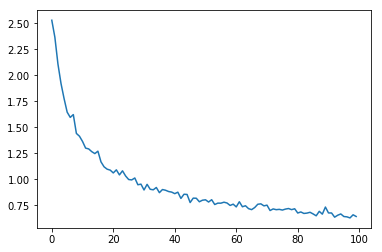

In [10]:
plt.plot(history_paper_model_100ep.history['loss'])
plt.show()

In [11]:
confusion_matrix_paper_model_100ep = confusion_matrix(dataTestWinLabel, np.argmax(results_paper_model_100ep, axis = 1))

Confusion matrix, without normalization
[[10085   494    40]
 [   18    67     3]
 [    9    24   296]]
Normalized confusion matrix
[[0.95 0.05 0.  ]
 [0.2  0.76 0.03]
 [0.03 0.07 0.9 ]]


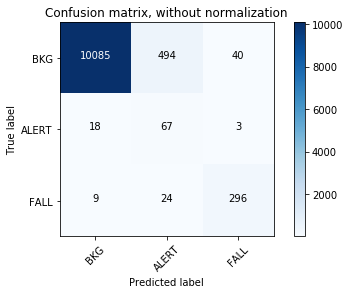

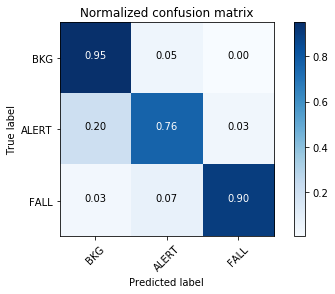

In [10]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix(confusion_matrix_paper_model_100ep, classes=['BKG', 'ALERT', 'FALL'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix(confusion_matrix_paper_model_100ep, classes=['BKG', 'ALERT', 'FALL'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [12]:
# Saving model
model_paper_model_100ep.save('paper_model_100ep.h5')

## Preliminar results with different model architectures

### 1. Functions

In [6]:
def PreliminaryRnnMmodel(w = 256, rnn_type = 'lstm', first_dense=True, batch_norm=True, two_rnn_layers=False):
    
    if not (rnn_type == 'lstm' or rnn_type == 'gru'):
        print("rnn_type must be 'lstm' or 'gru'")
        return
    
    rnn_model = Sequential()
    if (first_dense):
        rnn_model.add(Dense(32, batch_input_shape = (None, w, 3)))
        if (batch_norm):
            rnn_model.add(BatchNormalization())
    elif (batch_norm):
        rnn_model.add(BatchNormalization(batch_input_shape = (None, w, 3)))
        
    if two_rnn_layers:
        if not (first_dense or batch_norm):
            if rnn_type == 'lstm':
                rnn_model.add(CuDNNLSTM((32), batch_input_shape = (None, w, 3), return_sequences=True))
            elif rnn_type == 'gru':
                rnn_model.add(CuDNNGRU((32), batch_input_shape = (None, w, 3), return_sequences=True))
        else:
            if rnn_type == 'lstm':
                rnn_model.add(CuDNNLSTM((32), return_sequences=True))
            elif rnn_type == 'gru':
                rnn_model.add(CuDNNGRU((32), return_sequences=True))
    
    if not (first_dense or batch_norm):
        if rnn_type == 'lstm':
            rnn_model.add(CuDNNLSTM((32), batch_input_shape = (None, w, 3)))
        elif rnn_type == 'gru':
            rnn_model.add(CuDNNGRU((32), batch_input_shape = (None, w, 3)))
    else:    
        if rnn_type == 'lstm':
            rnn_model.add(CuDNNLSTM((32)))
        elif rnn_type == 'gru':
            rnn_model.add(CuDNNGRU((32)))
    
    rnn_model.add(Dense(3,activation='softmax'))
    
    return rnn_model

In [7]:
def trainPreliminaryRNNModel(dataTrVal, dataTrLab, dataTestVal, dataTestLab, epochs = 100, w = 256, rnn_type = 'lstm', first_dense=True, batch_norm=True, two_rnn_layers=False):
    
    dataTrLabelOneHot = to_categorical(dataTrLab)
    dataTestLabelOneHot = to_categorical(dataTestLab)
    
    model = PreliminaryRnnMmodel(w, rnn_type, first_dense, batch_norm, two_rnn_layers)
    
    model.summary()
    
    model_json = model.to_json()
    
    model.compile(optimizer='adam', loss=mlu.weighted_categorical_crossentropy(target_weights), metrics=['accuracy'])

    model_json = model.to_json()

    model_train_history = model.fit(dataTrVal, dataTrLabelOneHot, epochs=epochs, validation_data = (dataTestVal, dataTestLabelOneHot))

    model_prediction = model.predict(dataTestVal)

    model_confusion_matrix = confusion_matrix(dataTestLab, np.argmax(model_prediction, axis = 1))

    return model, model_train_history, model_confusion_matrix

### 2. Training set

In [9]:
import pandas as pd

model_set_name = 'researchset_pre128_2_only_gru'
w_list = [256]
stride_list = [128]
rnntype_list = ['gru']
first_dense_op = [False, True]
batch_norm_op = [False, True]
second_rnn_op = [False, True]
# Construction of data_frame with | model_id | param_1 | ... | param_n | as columns

info_list = list()
model_id = 1
for w in w_list:
    for stride in stride_list:
        for rnn_type in rnntype_list:
            for first_dense in first_dense_op:
                for batch_norm in batch_norm_op:
                    for two_rnn_layers in second_rnn_op:
                        #if (drop_rnn == 0.2 and drop_dense == 0):
                        #    print('dropout_rnn == 0.2 and dropout_dense == 0 jumped'.format())
                        #    continue
                        print([model_id, w, stride, rnn_type, first_dense, batch_norm, two_rnn_layers])
                        info_list.append([model_id, w, stride, rnn_type, first_dense, batch_norm, two_rnn_layers])
                        model_id += 1

info_dataframe = pd.DataFrame(info_list, columns = ['model_id', 'w', 'stride', 'rnn_type', 'first_dense', 'batch_norm', 'two_rnn_layers'])

## Saving the dataframe
info_dataframe.to_csv(model_set_name + '_research_summary.csv', index=False)

model_id = 1
for w in w_list:
    for stride in stride_list:
        for rnn_type in rnntype_list:
            for first_dense in first_dense_op:
                for batch_norm in batch_norm_op:
                    for two_rnn_layers in second_rnn_op:
                        #if (drop_rnn == 0.2 and drop_dense == 0):
                        #    print('dropout_rnn == 0.2 and dropout_dense == 0 jumped'.format())
                        #    continue
                        #if (model_id > 13):
                        print('\n=======================\nModel no. {}'.format(model_id))
                        results = trainPreliminaryRNNModel(dataTrWinValues[:,:,:3], dataTrWinLabel, dataTestWinValues[:,:,:3], dataTestWinLabel, epochs = 75, w = w, rnn_type=rnn_type, first_dense=first_dense, batch_norm=batch_norm, two_rnn_layers=two_rnn_layers)
                        train_info = results[1].history
                        eval_info = results[2]
                        model_performance_info = { 'train_history' : train_info, 'eval_results' : eval_info, 'optional_data' : 'n_test_subjects=8, w=256, stride=128'}
                        # Saving both model and performance_info
                        np.save(model_set_name + '_model_id_' + str(model_id) + '_info.npy', model_performance_info)
                        results[0].save(model_set_name + '_model_id_' + str(model_id) + '_fullmodel.h5')
                        model_id += 1

[1, 256, 128, 'gru', False, False, False]
[2, 256, 128, 'gru', False, False, True]
[3, 256, 128, 'gru', False, True, False]
[4, 256, 128, 'gru', False, True, True]
[5, 256, 128, 'gru', True, False, False]
[6, 256, 128, 'gru', True, False, True]
[7, 256, 128, 'gru', True, True, False]
[8, 256, 128, 'gru', True, True, True]

Model no. 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, 32)                3552      
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 99        
Total params: 3,651
Trainable params: 3,651
Non-trainable params: 0
_________________________________________________________________
Train on 94042 samples, validate on 22946 samples
Epoch 1/75
94042/94042 [==============================] - 37s 389us/step - loss: 2.4156 - acc: 0.6345 - val_loss: 2.2493 - val_acc: 0.6837
Epoch 2/75

Epoch 30/75
94042/94042 [==============================] - 56s 594us/step - loss: 0.5819 - acc: 0.9224 - val_loss: 1.3926 - val_acc: 0.8999
Epoch 31/75
94042/94042 [==============================] - 56s 594us/step - loss: 0.5635 - acc: 0.9260 - val_loss: 1.4879 - val_acc: 0.9104
Epoch 32/75
94042/94042 [==============================] - 56s 594us/step - loss: 0.5748 - acc: 0.9189 - val_loss: 1.5736 - val_acc: 0.8717
Epoch 33/75
94042/94042 [==============================] - 56s 593us/step - loss: 0.5652 - acc: 0.9223 - val_loss: 1.3333 - val_acc: 0.8773
Epoch 34/75
94042/94042 [==============================] - 56s 595us/step - loss: 0.5492 - acc: 0.9243 - val_loss: 1.3736 - val_acc: 0.8950
Epoch 35/75
94042/94042 [==============================] - 56s 593us/step - loss: 0.5522 - acc: 0.9241 - val_loss: 1.2997 - val_acc: 0.8731
Epoch 36/75
94042/94042 [==============================] - 56s 592us/step - loss: 0.5415 - acc: 0.9246 - val_loss: 1.4594 - val_acc: 0.8548
Epoch 37/75
94042/94

Epoch 8/75
94042/94042 [==============================] - 37s 397us/step - loss: 1.2798 - acc: 0.8050 - val_loss: 1.4138 - val_acc: 0.7967
Epoch 9/75
94042/94042 [==============================] - 37s 397us/step - loss: 1.2816 - acc: 0.7956 - val_loss: 2.0640 - val_acc: 0.6008
Epoch 10/75
94042/94042 [==============================] - 37s 393us/step - loss: 1.5408 - acc: 0.7956 - val_loss: 1.4861 - val_acc: 0.7943
Epoch 11/75
94042/94042 [==============================] - 37s 395us/step - loss: 1.2093 - acc: 0.8320 - val_loss: 1.3573 - val_acc: 0.7561
Epoch 12/75
94042/94042 [==============================] - 37s 394us/step - loss: 1.1291 - acc: 0.8321 - val_loss: 1.3148 - val_acc: 0.7499
Epoch 13/75
94042/94042 [==============================] - 37s 392us/step - loss: 1.0526 - acc: 0.8379 - val_loss: 1.2525 - val_acc: 0.7917
Epoch 14/75
94042/94042 [==============================] - 37s 395us/step - loss: 0.9769 - acc: 0.8604 - val_loss: 1.1441 - val_acc: 0.8811
Epoch 15/75
94042/9404

Epoch 43/75
94042/94042 [==============================] - 59s 623us/step - loss: 0.3710 - acc: 0.9450 - val_loss: 1.0121 - val_acc: 0.9186
Epoch 44/75
94042/94042 [==============================] - 59s 622us/step - loss: 0.3707 - acc: 0.9468 - val_loss: 1.0767 - val_acc: 0.9151
Epoch 45/75
94042/94042 [==============================] - 59s 624us/step - loss: 0.3628 - acc: 0.9459 - val_loss: 1.4174 - val_acc: 0.9333
Epoch 46/75
94042/94042 [==============================] - 59s 625us/step - loss: 0.3960 - acc: 0.9436 - val_loss: 1.2431 - val_acc: 0.9459
Epoch 47/75
94042/94042 [==============================] - 59s 623us/step - loss: 0.3421 - acc: 0.9476 - val_loss: 1.4514 - val_acc: 0.9383
Epoch 48/75
94042/94042 [==============================] - 59s 622us/step - loss: 0.3438 - acc: 0.9474 - val_loss: 1.0208 - val_acc: 0.9291
Epoch 49/75
94042/94042 [==============================] - 59s 623us/step - loss: 0.3559 - acc: 0.9464 - val_loss: 1.0925 - val_acc: 0.9411
Epoch 50/75
94042/94

Epoch 21/75
94042/94042 [==============================] - 38s 408us/step - loss: 1.7297 - acc: 0.8105 - val_loss: 2.1077 - val_acc: 0.7557
Epoch 22/75
94042/94042 [==============================] - 37s 397us/step - loss: 1.7183 - acc: 0.8166 - val_loss: 2.1921 - val_acc: 0.7627
Epoch 23/75
94042/94042 [==============================] - 37s 395us/step - loss: 1.7368 - acc: 0.8169 - val_loss: 2.0461 - val_acc: 0.7696
Epoch 24/75
94042/94042 [==============================] - 38s 399us/step - loss: 1.7722 - acc: 0.8119 - val_loss: 1.9115 - val_acc: 0.7533
Epoch 25/75
94042/94042 [==============================] - 37s 392us/step - loss: 1.7131 - acc: 0.8157 - val_loss: 1.9853 - val_acc: 0.7592
Epoch 26/75
94042/94042 [==============================] - 37s 389us/step - loss: 1.8891 - acc: 0.8221 - val_loss: 2.2415 - val_acc: 0.7586
Epoch 27/75
94042/94042 [==============================] - 36s 388us/step - loss: 1.7786 - acc: 0.8118 - val_loss: 2.0509 - val_acc: 0.7747
Epoch 28/75
94042/94

Train on 94042 samples, validate on 22946 samples
Epoch 1/75
94042/94042 [==============================] - 59s 628us/step - loss: 1.9990 - acc: 0.7013 - val_loss: 1.8994 - val_acc: 0.8160
Epoch 2/75
94042/94042 [==============================] - 57s 610us/step - loss: 1.5289 - acc: 0.8121 - val_loss: 1.5508 - val_acc: 0.8486
Epoch 3/75
94042/94042 [==============================] - 57s 607us/step - loss: 1.2738 - acc: 0.8514 - val_loss: 1.3730 - val_acc: 0.8201
Epoch 4/75
94042/94042 [==============================] - 57s 606us/step - loss: 1.1814 - acc: 0.8692 - val_loss: 1.4102 - val_acc: 0.8735
Epoch 5/75
94042/94042 [==============================] - 57s 605us/step - loss: 1.2290 - acc: 0.8719 - val_loss: 1.3560 - val_acc: 0.8155
Epoch 6/75
94042/94042 [==============================] - 57s 605us/step - loss: 1.1305 - acc: 0.8844 - val_loss: 1.3079 - val_acc: 0.8525
Epoch 7/75
94042/94042 [==============================] - 57s 605us/step - loss: 1.0740 - acc: 0.8867 - val_loss: 1.

Epoch 36/75
94042/94042 [==============================] - 40s 425us/step - loss: 0.5767 - acc: 0.9344 - val_loss: 1.1662 - val_acc: 0.8732
Epoch 37/75
94042/94042 [==============================] - 40s 427us/step - loss: 0.5747 - acc: 0.9319 - val_loss: 1.2996 - val_acc: 0.8785
Epoch 38/75
94042/94042 [==============================] - 40s 426us/step - loss: 0.5619 - acc: 0.9311 - val_loss: 1.0874 - val_acc: 0.9128
Epoch 39/75
94042/94042 [==============================] - 40s 424us/step - loss: 0.5908 - acc: 0.9297 - val_loss: 1.1379 - val_acc: 0.8716
Epoch 40/75
94042/94042 [==============================] - 40s 427us/step - loss: 0.5668 - acc: 0.9305 - val_loss: 1.2281 - val_acc: 0.9307
Epoch 41/75
94042/94042 [==============================] - 40s 429us/step - loss: 0.5365 - acc: 0.9350 - val_loss: 1.0983 - val_acc: 0.8918
Epoch 42/75
94042/94042 [==============================] - 40s 426us/step - loss: 0.5646 - acc: 0.9325 - val_loss: 1.0369 - val_acc: 0.9181
Epoch 43/75
94042/94

Epoch 12/75
94042/94042 [==============================] - 61s 649us/step - loss: 0.6629 - acc: 0.9220 - val_loss: 0.9650 - val_acc: 0.8831
Epoch 13/75
94042/94042 [==============================] - 61s 649us/step - loss: 0.6654 - acc: 0.9247 - val_loss: 0.8797 - val_acc: 0.9250
Epoch 14/75
94042/94042 [==============================] - 61s 652us/step - loss: 0.6420 - acc: 0.9227 - val_loss: 0.9811 - val_acc: 0.8630
Epoch 15/75
94042/94042 [==============================] - 61s 651us/step - loss: 0.6176 - acc: 0.9294 - val_loss: 1.1631 - val_acc: 0.9125
Epoch 16/75
94042/94042 [==============================] - 61s 651us/step - loss: 0.5943 - acc: 0.9323 - val_loss: 1.0177 - val_acc: 0.8923
Epoch 17/75
94042/94042 [==============================] - 61s 648us/step - loss: 0.6037 - acc: 0.9287 - val_loss: 0.9213 - val_acc: 0.9154
Epoch 18/75
94042/94042 [==============================] - 61s 649us/step - loss: 0.5875 - acc: 0.9300 - val_loss: 0.8730 - val_acc: 0.8872
Epoch 19/75
94042/94

## Analysis of results

In [9]:
import pandas as pd
from keras.models import load_model

research_set_folder = 'researchset_pre128_1'

### Model table

In [10]:
research_set_table = pd.read_csv(research_set_folder + '/' + research_set_folder + '_research_summary.csv')
research_set_table

,model_id,w,stride,rnn_type,first_dense,batch_norm,two_rnn_layers
0,1,256,128,lstm,False,False,False
1,2,256,128,lstm,False,False,True
2,3,256,128,lstm,False,True,False
3,4,256,128,lstm,False,True,True
4,5,256,128,lstm,True,False,False
5,6,256,128,lstm,True,False,True
6,7,256,128,lstm,True,True,False
7,8,256,128,lstm,True,True,True
8,9,256,128,gru,False,False,False
9,10,256,128,gru,False,False,True


### Independent model results

#### Show results

In [53]:
ex_model_info = np.load(research_set_folder + '/' + research_set_folder +  '_model_id_16_info.npy')
ex_model_info = ex_model_info[()]
ex_model_info['optional_data']

'n_test_subjects=8, w=256, stride=128'

* #### Train history

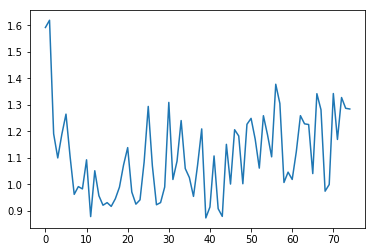

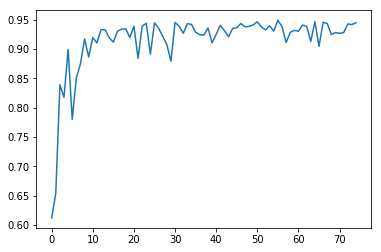

In [54]:
train_history = ex_model_info['train_history']
plt.plot(train_history['val_loss'])
plt.show()
plt.plot(train_history['val_acc'])
plt.show()

* #### Evaluation with test set

Normalized confusion matrix
[[0.95 0.04 0.01]
 [0.17 0.77 0.06]
 [0.01 0.02 0.97]]
Confusion matrix, without normalization
[[20800   935   232]
 [   58   263    21]
 [    4    14   619]]


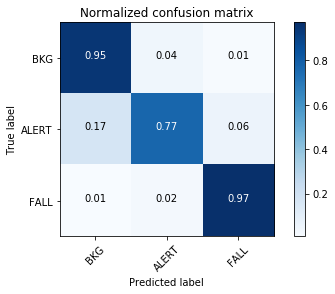

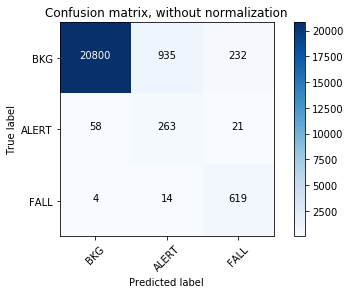

In [55]:
eval_results = ex_model_info['eval_results']
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix(eval_results, classes=['BKG', 'ALERT', 'FALL'], normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plt.figure()
mlu.plot_confusion_matrix(eval_results, classes=['BKG', 'ALERT', 'FALL'],
                      title='Confusion matrix, without normalization')

plt.show()

#### Load model

In [58]:
ex_model = load_model(research_set_folder + '/' + research_set_folder + '_model_id_7_fullmodel.h5', custom_objects={'loss': mlu.weighted_categorical_crossentropy(target_weights)})
ex_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256, 32)           128       
_________________________________________________________________
batch_normalization_3 (Batch (None, 256, 32)           128       
_________________________________________________________________
cu_dnnlstm_10 (CuDNNLSTM)    (None, 32)                8448      
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 99        
Total params: 8,803
Trainable params: 8,739
Non-trainable params: 64
_________________________________________________________________


### FLOPS calc

In [19]:
import tensorflow as tf
run_meta = tf.RunMetadata()
with tf.Session(graph=tf.Graph()) as sess:
    K.set_session(sess)
    net = ex_model

    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops = tf.profiler.profile(sess.graph, run_meta=run_meta, cmd='op', options=opts)

    opts = tf.profiler.ProfileOptionBuilder.trainable_variables_parameter()    
    params = tf.profiler.profile(sess.graph, run_meta=run_meta, cmd='op', options=opts)

    print("{:,} --- {:,}".format(flops.total_float_ops, params.total_parameters))

0 --- 0
